# **Importing Libraries**

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 20.1 MB/s 
     |████████████████████████████████| 7.6 MB 70.8 MB/s 
     |████████████████████████████████| 182 kB 73.6 MB/s 


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from transformers import BertTokenizer, BertModel

# **Data Preprocessing**

In [3]:
datapath = f'/content/Intent_Finer139_final.xlsx'
df = pd.read_excel(datapath, sheet_name='Finer-139')
df.head()

,Labels,Intents,MainIntent
0,AccrualForEnvironmentalLossContingencies,"Accrual, Loss",Accrual
1,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"Assets, UsefulLife",Assets
2,AllocatedShareBasedCompensationExpense,"Compensation, Expense, Shares",Expense
3,AmortizationOfFinancingCosts,"Amortization, Costs",Amortization
4,AmortizationOfIntangibleAssets,"Amortization, Assets",Amortization


In [4]:
df.shape

(139, 3)

In [5]:
intent_df = pd.read_excel(datapath, sheet_name='Intents')
intent_df.head()

,Intent
0,Accrual
1,Acquisition
2,Amortization
3,Amount
4,Assets


In [6]:
#Create a map for intent2idx
intent2idx = {}
intent2idx['NA'] = 0

In [7]:
intent_arr = intent_df.to_numpy()
intent_arr = np.squeeze(intent_arr, axis=1)

In [8]:
intent_arr = np.insert(intent_arr, 0, 'NA')

In [9]:
intent_arr

array(['NA', 'Accrual', 'Acquisition', 'Amortization', 'Amount', 'Assets',
       'Combination', 'Costs', 'Debt', 'Depreciation', 'Equity',
       'Expense', 'Interest', 'LeaseTerm', 'Liability', 'Line of Credit',
       'Loss', 'OperatingLease', 'Options', 'Other', 'Ownership',
       'Payment', 'Price', 'Revenue', 'Share', 'Shares', 'Stock', 'Tax',
       'TaxRate', 'UsefulLife'], dtype=object)

In [10]:
for idx, item in enumerate(intent_arr):
  intent2idx[item] = idx

In [11]:
for key, val in intent2idx.items():
  print(key, val)

NA 0
Accrual 1
Acquisition 2
Amortization 3
Amount 4
Assets 5
Combination 6
Costs 7
Debt 8
Depreciation 9
Equity 10
Expense 11
Interest 12
LeaseTerm 13
Liability 14
Line of Credit 15
Loss 16
OperatingLease 17
Options 18
Other 19
Ownership 20
Payment 21
Price 22
Revenue 23
Share 24
Shares 25
Stock 26
Tax 27
TaxRate 28
UsefulLife 29


#**Importing datsets**

In [12]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 37.6 MB/s 
     |████████████████████████████████| 132 kB 64.5 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 127 kB 83.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [13]:
import datasets

In [14]:
finer_train = datasets.load_dataset("nlpaueb/finer-139", split="train")
finer_tag_names = finer_train.features["ner_tags"].feature.names

Generating train split:   0%|          | 0/900384 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/112494 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/108378 [00:00<?, ? examples/s]

Dataset finer-139 downloaded and prepared to /root/.cache/huggingface/datasets/nlpaueb___finer-139/finer-139/1.0.0/5f5a8eb2a38e8b142bb8ca63f3f9600634cc6c8963e4c982926cf2b48e4e55ff. Subsequent calls will reuse this data.


In [15]:
# len(finer_train)

In [16]:
# train_df = finer_train.to_pandas()

In [17]:
# train_df.shape

In [18]:
# train_df.head()

In [19]:
# ner_tag_dist = train_df['ner_tags'].apply(lambda x: np.concatenate([x])).values

In [20]:
# ner_tag_dist = np.hstack(ner_tag_dist)

In [21]:
# ner_tag_dist = ner_tag_dist[ner_tag_dist != 0]

In [22]:
# plt.hist(ner_tag_dist, bins=np.arange(280))
# plt.show()

# **Utility Functions**

In [23]:
# Note : When, there are multiple modes in an array, the function returns the smallest of them
def get_most_freq(arr):
  # arr: np.array
  freq_arr = np.bincount(arr)

  most_freq_element = np.argmax(freq_arr)
  if(most_freq_element != 0):
    return most_freq_element

  # All the elements in the arr are zero
  if(freq_arr[most_freq_element] == arr.size):
    return 0

  # There is atleast one non-zero element in arr
  freq_arr[most_freq_element] = 0 
  second_most_freq_element = np.argmax(freq_arr)
  return second_most_freq_element

In [24]:
def get_label(tag_idx):
  # If tag_idx is zero, then all elements are zero
  if(tag_idx == 0):
    return 0

  # If tag_idx is non-zero, then get the tag_name (string)
  tag_name = finer_tag_names[tag_idx][2:]
  # After getting the sliced tag_name, find the corresponding row_idx in the df
  row_index = df.index[df['Labels'] == tag_name][0]
  # After getting the corresponding row_index, get the main_intent (string)
  # And, then convert it into the label
  label = intent2idx[df.at[row_index, 'MainIntent']]
  return label

In [25]:
def get_text(token_list):
  # token_list --> numpy array of strings
  return " ".join(token_list.tolist())

In [26]:
# train_df['main_tag'] = train_df['ner_tags'].apply(lambda x : get_most_freq(x))

# **Creating DataFrames**

In [27]:
# ner_tags
# O --> 0
# B-AccrualForEnvironmentalLossContingencies --> 1
# B-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife --> 2

# 1. For each text in the training dataset, find the main_tag value
# 2. a) If it is zero, then there it belongs to NA category --> label = 0
#    b) If it is non-zero, then find the str = finer_tag_names[main_tag] --> Extract, str = str[2:] -->
#       --> find the corresponding index --> row_index = df.index[df['Labels'] == str][0]
# 3. After getting the index, find the value of the label --> label = intent2idx[df.at[row_index, 'MainIntent']]

In [28]:
# Important Datas:
# 1. intent2idx
# 2. intent_arr
# 3. train_df
# 4. df
# 5. finer_tag_names

In [29]:
# print(finer_tag_names)

In [30]:
print(intent_arr)
print(len(intent_arr))

['NA' 'Accrual' 'Acquisition' 'Amortization' 'Amount' 'Assets'
 'Combination' 'Costs' 'Debt' 'Depreciation' 'Equity' 'Expense' 'Interest'
 'LeaseTerm' 'Liability' 'Line of Credit' 'Loss' 'OperatingLease'
 'Options' 'Other' 'Ownership' 'Payment' 'Price' 'Revenue' 'Share'
 'Shares' 'Stock' 'Tax' 'TaxRate' 'UsefulLife']
30


In [31]:
# print(intent2idx)
# print(len(intent2idx))

In [32]:
# df.head()

In [33]:
# train_df.head()

In [34]:
# def get_label(tag_idx):
#   # If tag_idx is zero, then all elements are zero
#   if(tag_idx == 0):
#     return 0

#   # If tag_idx is non-zero, then get the tag_name (string)
#   tag_name = finer_tag_names[tag_idx][2:]
#   # After getting the sliced tag_name, find the corresponding row_idx in the df
#   # After getting the corresponding row_index, get the main_intent (string)
#   row_index = df.index[df['Labels'] == tag_name][0]
#   # And, then convert it into the label
#   label = intent2idx[df.at[row_index, 'MainIntent']]
#   return label

In [35]:
# train_df['label'] = train_df['main_tag'].apply(lambda x : get_label(x))

In [36]:
# def get_text(token_list):
#   # token_list --> numpy array of strings
#   return " ".join(token_list.tolist())

In [37]:
# train_df['text'] = train_df['tokens'].apply(lambda x : get_text(x))

In [38]:
# column_to_move = train_df.pop("text")
# train_df.insert(train_df.shape[1]-1, "text", column_to_move)

In [39]:
# train_df.head()

In [40]:
# print(intent_arr) # Labels
# print(intent2idx) # Label2idx

In [41]:
def process_df(df):
  df['main_tag'] = df['ner_tags'].apply(lambda x : get_most_freq(x))
  df['label'] = df['main_tag'].apply(lambda x : get_label(x))
  df['text'] = df['tokens'].apply(lambda x : get_text(x))
  column_to_move = df.pop("text")
  df.insert(df.shape[1]-1, "text", column_to_move)

In [42]:
train_df = finer_train.to_pandas()

In [43]:
finer_valid = datasets.load_dataset("nlpaueb/finer-139", split="validation")
valid_df = finer_valid.to_pandas()

In [44]:
finer_test = datasets.load_dataset("nlpaueb/finer-139", split="test")
test_df = finer_test.to_pandas()

In [45]:
process_df(train_df)

In [46]:
process_df(valid_df)

In [47]:
process_df(test_df)

In [48]:
train_df.head()

,id,tokens,ner_tags,main_tag,text,label
0,0,"[ITEM, 1, Financial, Statements, Lennar, Corpo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",66,ITEM 1 Financial Statements Lennar Corporation...,10
1,1,"[See, accompanying, notes, to, condensed, cons...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,See accompanying notes to condensed consolidat...,0
2,2,"[The, condensed, consolidated, financial, stat...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,The condensed consolidated financial statement...,0
3,3,"[These, condensed, consolidated, financial, st...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,These condensed consolidated financial stateme...,0
4,4,"[The, condensed, consolidated, statements, of,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,The condensed consolidated statements of opera...,0


In [49]:
valid_df.head()

,id,tokens,ner_tags,main_tag,text,label
0,900384,"[Revenue, by, segment, and, geography, for, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,Revenue by segment and geography for the three...,0
1,900385,"[The, total, amount, of, revenue, recognized, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",32,The total amount of revenue recognized during ...,14
2,900386,"[Revenue, from, product, sales, is, typically,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,Revenue from product sales is typically recogn...,0
3,900387,"[At, December, 31, ,, 2019, ,, $, 515, thousan...","[0, 0, 0, 0, 0, 0, 0, 132, 0, 0, 0, 0, 0, 0, 0...",132,"At December 31 , 2019 , $ 515 thousand of unea...",23
4,900388,"[At, March, 31, ,, 2020, ,, the, unearned, amo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 132, 0, 0]",132,"At March 31 , 2020 , the unearned amount was $...",23


In [50]:
test_df.head()

,id,tokens,ner_tags,main_tag,text,label
0,1012878,"[The, changes, in, the, fair, value, of, the, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,The changes in the fair value of the derivativ...,0
1,1012879,"[Fair, Values, Financial, Assets, and, Financi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,Fair Values Financial Assets and Financial Lia...,0
2,1012880,"[23, Table, of, Contents, AMERICAN, EXPRESS, C...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,23 Table of Contents AMERICAN EXPRESS CREDIT C...,0
3,1012881,"[The, fair, values, of, these, financial, inst...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,The fair values of these financial instruments...,0
4,1012882,"[(, b, ), Level, 1, amounts, reflect, interest...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,( b ) Level 1 amounts reflect interest - beari...,0


# **Data Visualization**

In [51]:
# Data visualization
def visualize_df(df):
  ner_tag_dist = df['ner_tags'].apply(lambda x: np.concatenate([x])).values
  ner_tag_dist = np.hstack(ner_tag_dist)
  ner_tag_dist = ner_tag_dist[ner_tag_dist != 0]
  plt.hist(ner_tag_dist, bins=np.arange(280))
  plt.show()

(900384, 6)


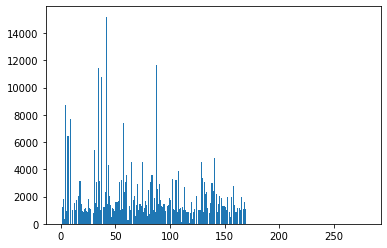

In [52]:
print(train_df.shape)
visualize_df(train_df)

(112494, 6)


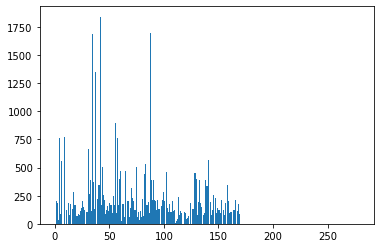

In [53]:
print(valid_df.shape)
visualize_df(valid_df)

(108378, 6)


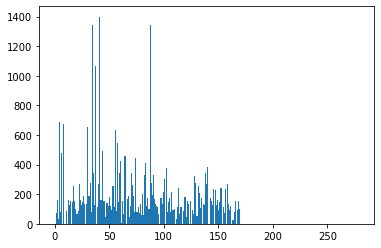

In [54]:
print(test_df.shape)
visualize_df(test_df)

#Model Training

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [56]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['label'].tolist()
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [57]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 30)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [58]:
def train(model, train, val, learning_rate, epochs):

    # train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)


    if use_cuda:
      print("Utilizing GPU")
      model = model.cuda()
      criterion = criterion.cuda()
    
    print("Training Started")
    for epoch_num in range(epochs):
      total_acc_train = 0
      total_loss_train = 0

      for train_input, train_label in tqdm(train_dataloader):
        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        # print(mask.shape)
        # print(input_id.shape)
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()
        
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
            
      total_acc_val = 0
      total_loss_val = 0

      with torch.no_grad():

        for val_input, val_label in val_dataloader:
          val_label = val_label.to(device)
          mask = val_input['attention_mask'].to(device)
          input_id = val_input['input_ids'].squeeze(1).to(device)

          output = model(input_id, mask)
          # print(output)
          # print(val_label.long())

          batch_loss = criterion(output, val_label.long())
          total_loss_val += batch_loss.item()
          
          acc = (output.argmax(dim=1) == val_label).sum().item()
          total_acc_val += acc
            
      print(
          f'''Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train.labels): .3f} | 
          Train Accuracy: {total_acc_train / len(train.labels): .3f} | Val Loss: {total_loss_val / len(val.labels): .3f} | 
          Val Accuracy: {total_acc_val / len(val.labels): .3f}''')
      
    print("Training Finished")                  

In [59]:
def evaluate(model, test):
  # test = Dataset(test_data)
  test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  if use_cuda:
    model = model.cuda()

  total_acc_test = 0
  with torch.no_grad():
    for test_input, test_label in test_dataloader:
      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      acc = (output.argmax(dim=1) == test_label).sum().item()
      total_acc_test += acc

  print(f'Test Accuracy: {total_acc_test / len(test): .3f}')

In [60]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
# train_size = train_df.shape[0]
# valid_size = valid_df.shape[0]

In [62]:
# valid_split_len = valid_size//4
# valid_set1 = valid_df.iloc[0:valid_split_len, :]
# valid_loader_set1 = Dataset(valid_set1)

In [63]:
# train_split_len = train_size//4
# train_set1 = train_df.iloc[0:train_split_len, :]
# train_loader_set1 = Dataset(train_set1)

In [64]:
# len(train_loader_set1.labels)

In [65]:
# len(valid_loader_set1.labels)

In [66]:
# len(train_loader_set1.labels)

In [67]:
# Randomly sample 3000 training samples, 2000 validation samples
train_sample = train_df.sample(n=3000, random_state=1)
train_sample = train_sample.reset_index(drop=True)
train_loader_set = Dataset(train_sample)

valid_sample = valid_df.sample(n=2000, random_state=1)
valid_sample = valid_sample.reset_index(drop=True)
valid_loader_set = Dataset(valid_sample)

In [68]:
train(model, train_loader_set, valid_loader_set, LR, EPOCHS)

Utilizing GPU
Training Started


100%|██████████| 3000/3000 [06:30<00:00,  7.68it/s]


Epochs: 1 | Train Loss:  1.429 | 
          Train Accuracy:  0.721 | Val Loss:  1.096 | 
          Val Accuracy:  0.789


100%|██████████| 3000/3000 [06:28<00:00,  7.72it/s]


Epochs: 2 | Train Loss:  0.962 | 
          Train Accuracy:  0.805 | Val Loss:  1.036 | 
          Val Accuracy:  0.789


100%|██████████| 3000/3000 [06:28<00:00,  7.72it/s]


Epochs: 3 | Train Loss:  0.885 | 
          Train Accuracy:  0.806 | Val Loss:  0.987 | 
          Val Accuracy:  0.789


100%|██████████| 3000/3000 [06:28<00:00,  7.72it/s]


Epochs: 4 | Train Loss:  0.822 | 
          Train Accuracy:  0.810 | Val Loss:  1.022 | 
          Val Accuracy:  0.774


100%|██████████| 3000/3000 [06:28<00:00,  7.72it/s]


Epochs: 5 | Train Loss:  0.770 | 
          Train Accuracy:  0.815 | Val Loss:  1.000 | 
          Val Accuracy:  0.789
Training Finished


In [69]:
# Randomly sample 2000 test samples & download them
test_sample = test_df.sample(n=2000, random_state=1)
test_sample = test_sample.reset_index(drop=True)

In [71]:
test_loader_set = Dataset(test_sample)

In [72]:
evaluate(model, test_loader_set)

Test Accuracy:  0.840


In [75]:
# Download the test dataset
test_sample.to_excel("test_set.xlsx")

In [ ]:
# train_split_len = train_size//4
# train_set1 = train_df.iloc[0:train_split_len, :]
# train_set2 = train_df.iloc[train_split_len:2*train_split_len, :]
# train_set3 = train_df.iloc[2*train_split_len:3*train_split_len, :]
# train_set4 = train_df.iloc[3*train_split_len:, :]

In [ ]:
# valid_split_len = valid_size//4
# valid_set1 = valid_df.iloc[0:valid_split_len, :]
# valid_set2 = valid_df.iloc[valid_split_len:2*valid_split_len, :]
# valid_set3 = valid_df.iloc[2*valid_split_len:3*valid_split_len, :]
# valid_set4 = valid_df.iloc[3*valid_split_len:, :]

In [ ]:
# train_loader_set1 = Dataset(train_set1)
# valid_loader_set1 = Dataset(valid_set1)
# train(model, train_loader_set1, valid_loader_set1, LR, EPOCHS)

In [ ]:
# train_loader_set2 = Dataset(train_set2)
# valid_loader_set2 = Dataset(valid_set2)
# train(model, train_loader_set2, valid_loader_set2, LR, EPOCHS)

In [ ]:
# train_loader_set3 = Dataset(train_set3)
# valid_loader_set3 = Dataset(valid_set3)
# train(model, train_loader_set3, valid_loader_set3, LR, EPOCHS)

In [ ]:
# train_loader_set4 = Dataset(train_set4)
# valid_loader_set4 = Dataset(valid_set4)
# train(model, train_loader_set4, valid_loader_set4, LR, EPOCHS)

In [ ]:
# val_loader_set = Dataset(valid_df)

In [ ]:
# train(model, train_loader_set, val_loader_set, LR, EPOCHS)

In [ ]:
# evaluate(model, test_df)